### imports


In [79]:
# ipython extension to autoreload imported modules so that any changes will be up to date before running code in this nb
%load_ext autoreload 
%autoreload 2

# libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.keras.layers import Dense

from tensorflow.python.keras import Model
from tensorflow.python.keras.layers import Dense, Dropout
from tensorflow.python.keras.metrics import RootMeanSquaredError, MeanSquaredError
from spektral.layers import GCNConv, GlobalSumPool
from spektral.models import GCN
from spektral.data import MixedLoader
from lorenz import lorenzDataset, DEFAULT_TIME_RESOLUTION
from plotters import plot_with_predictions, plot_true_vs_pred

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


THINGS TO TRY 
- write helper functions! 
- play with diff sample size (500) - v
- input/output day ratio - h 
- play around with buffer - v
- activation layers - h
- play with the hidden layers - v 
- diff data samples / diff lorenz params - h 
- diff optimizer alg - v 

### helper functions for hyperparameter testing

In [39]:
def make_train_model(train,
                     channels=32,
                     activation="relu",
                     use_bias=False,
                     dropout_rate=0,
                     l2_reg=0,
                     optimizer='adam',
                     loss='mean_squared_error',
                     epochs=200):
    # prepare data
    train_loader = MixedLoader(dataset=train, batch_size=32)

    # create and train model
    GCN_model = GCN(
        n_labels=1,
        channels=channels,  # i.e. n_hidden layers in each GCNConv layer
        activation=activation,
        output_activation=None,  # we want regression, i.e. a linear function
        use_bias=use_bias,
        dropout_rate=dropout_rate,
        l2_reg=l2_reg)

    GCN_model.compile(optimizer=optimizer, loss=loss)

    history = GCN_model.fit(train_loader.load(),
                            steps_per_epoch=train_loader.steps_per_epoch,
                            epochs=epochs)
    return GCN_model, history


In [80]:
def plot_model_results(train, val, GCN_model, history, epochs=200):
    # plot training MSE
    fig_train_loss, ax = plt.subplots(1, 1, figsize=(4, 3))
    ax.plot(history.history['loss'])
    ax.set_ylabel('mean squared error')
    ax.set_xlabel('epochs')
    fig_train_loss.suptitle('model MSE over training epochs')
    ax.text(x=epochs - 75,
            y=2 * history.history['loss'][-1],
            s="final loss: {:.2f}".format(history.history['loss'][-1]))

    # plot train predictions
    fig_train_pred, (ax0,
                     ax1) = plot_with_predictions(model=GCN_model,
                                                  graph_dataset=train,
                                                  Loader=MixedLoader,
                                                  batch_size=32,
                                                  node=0,
                                                  model_name='GCN OOTB train')

    # plot val predictions
    fig_val_pred, (ax0, ax1) = plot_with_predictions(model=GCN_model,
                                                     graph_dataset=val,
                                                     Loader=MixedLoader,
                                                     batch_size=32,
                                                     node=0,
                                                     model_name='GCN OOTB val')

    # # plot predictions against true value
    # fig_true_vs_pred, ax = plot_true_vs_pred(y_true, y_pred)

    plt.tight_layout()
    return fig_train_loss, fig_train_pred, fig_val_pred

### prepare data


In [71]:
# TODO: add logging to see progress

# only uncomment each line if testing a non-default parameter
dataset = lorenzDataset(
    # n_samples=1 / DEFAULT_TIME_RESOLUTION,
    # input_steps=2 / DEFAULT_TIME_RESOLUTION,  # 2 days
    # output_delay=1 / DEFAULT_TIME_RESOLUTION,  # 1 day
    # output_steps=1,
    min_buffer=-3 / DEFAULT_TIME_RESOLUTION,
    # rand_buffer=False,
    # K=36,
    # F=8,
    # c=10,
    # b=10,
    # h=1,
    # coupled=True,
    # time_resolution=DEFAULT_TIME_RESOLUTION,
    # seed=42
)

train = dataset[:int(0.7 * dataset.n_graphs)]
val = dataset[int(0.7 * dataset.n_graphs):int(0.9 * dataset.n_graphs)]
test = dataset[int(0.9 * dataset.n_graphs):]

# normalize data
X1_mean, X1_std, X2_mean, X2_std = train.get_mean_std()

train.normalize(X1_mean, X1_std, X2_mean, X2_std)
val.normalize(X1_mean, X1_std, X2_mean, X2_std)
test.normalize(X1_mean, X1_std, X2_mean, X2_std)

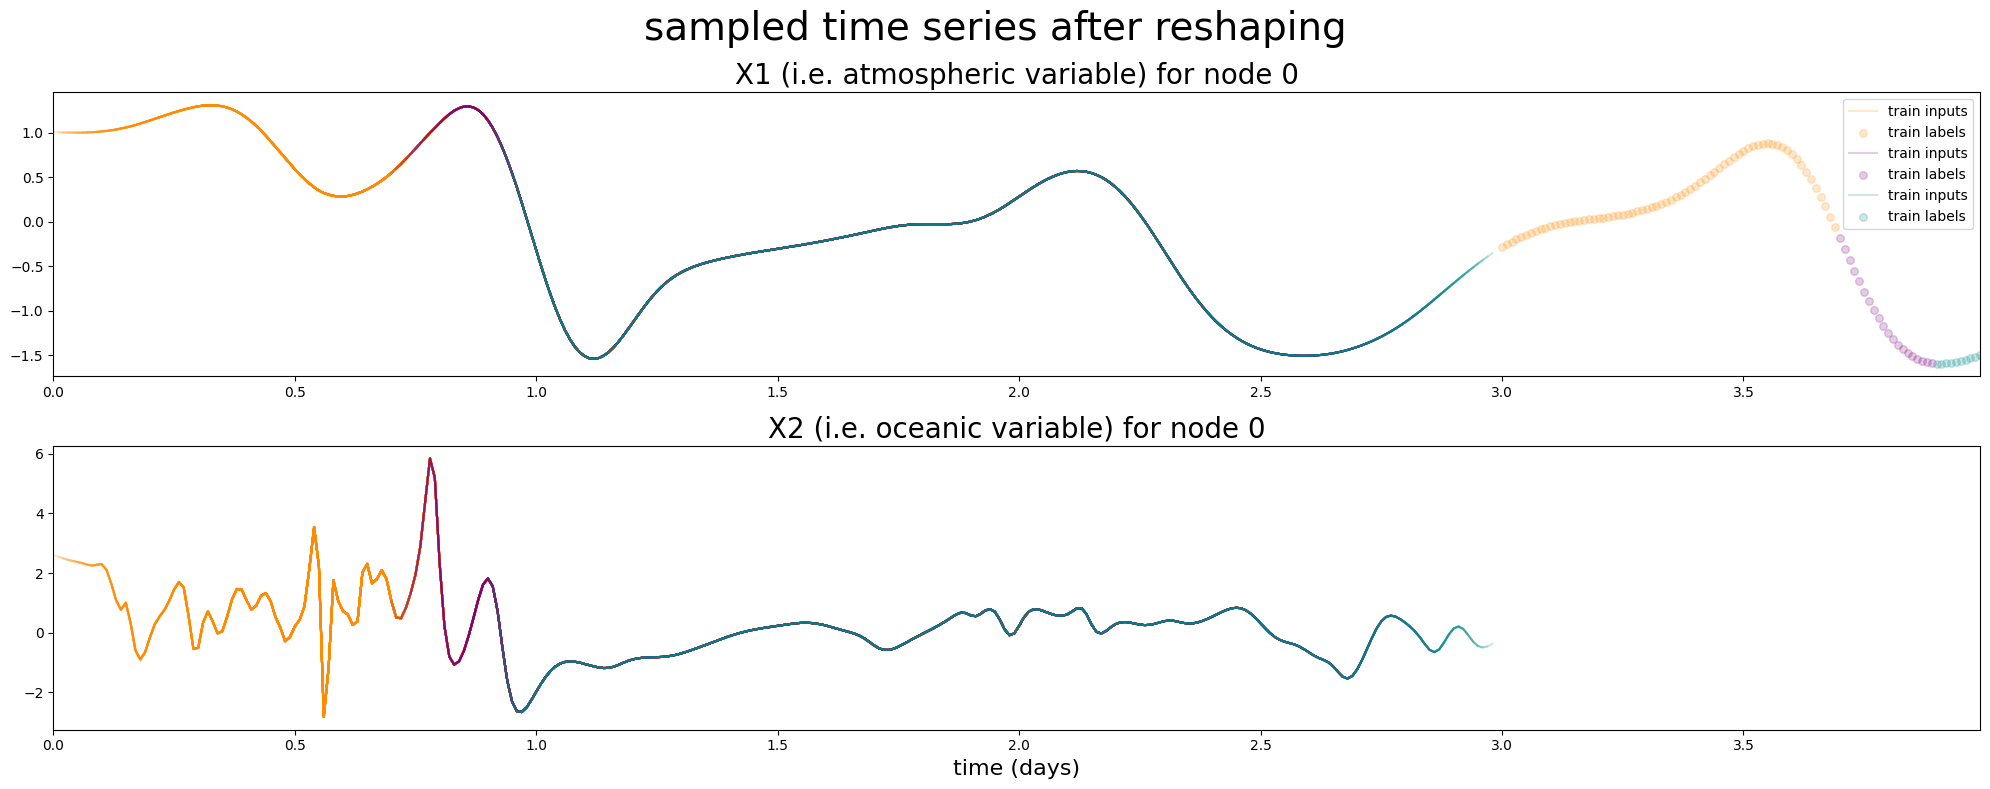

In [72]:
colors = ["darkorange", "purple", "darkcyan"]
node = 0

# set up plot
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(20, 8))

fig.suptitle("sampled time series after reshaping", size=28)
ax0.set_title("X1 (i.e. atmospheric variable) for node {}".format(node),
              size=20)
ax1.set_title("X2 (i.e. oceanic variable) for node {}".format(node), size=20)
plt.xlabel('time (days)', size=16)

# plot train, val, and test data
fig, (ax0, ax1) = train.plot(node,
                             fig,
                             ax0,
                             ax1,
                             data_type='train',
                             color=colors[0], alpha=0.2)
fig, (ax0, ax1) = val.plot(node,
                           fig,
                           ax0,
                           ax1,
                           data_type='val',
                           color=colors[1], alpha=0.2)
fig, (ax0, ax1) = test.plot(node,
                            fig,
                            ax0,
                            ax1,
                            data_type='test',
                            color=colors[2], alpha=0.2)

ax0.set_xlim(train[0].t_X[0], test[-1].t_Y[-1])
ax1.set_xlim(train[0].t_X[0], test[-1].t_Y[-1])

# create legend
ax0.legend()
ax0.legend(handles=ax0.get_legend().legendHandles[0:6])
leg = ax0.get_legend()
[
    leg.legendHandles[i].set_color(colors[i // 2])
    for i in range(len(leg.legendHandles))
]

plt.tight_layout()
plt.show()

### test hyperparameters

In [86]:
model, history = make_train_model(train, activation="tanh")

Epoch 1/200
3/3 [==============================] - 1s 5ms/step - loss: 5.4516
Epoch 2/200
3/3 [==============================] - 0s 4ms/step - loss: 3.5625
Epoch 3/200
3/3 [==============================] - 0s 4ms/step - loss: 2.3606
Epoch 4/200
3/3 [==============================] - 0s 4ms/step - loss: 1.8145
Epoch 5/200
3/3 [==============================] - 0s 4ms/step - loss: 1.4472
Epoch 6/200
3/3 [==============================] - 0s 4ms/step - loss: 1.2257
Epoch 7/200
3/3 [==============================] - 0s 4ms/step - loss: 0.9991
Epoch 8/200
3/3 [==============================] - 0s 4ms/step - loss: 0.8927
Epoch 9/200
3/3 [==============================] - 0s 4ms/step - loss: 0.7950
Epoch 10/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6895
Epoch 11/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6339
Epoch 12/200
3/3 [==============================] - 0s 4ms/step - loss: 0.5897
Epoch 13/200
3/3 [==============================] - 0s 4ms/st

1/1 [==============================] - 0s 26ms/step


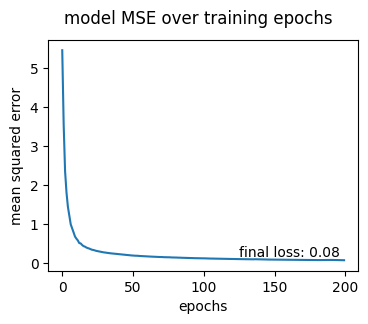

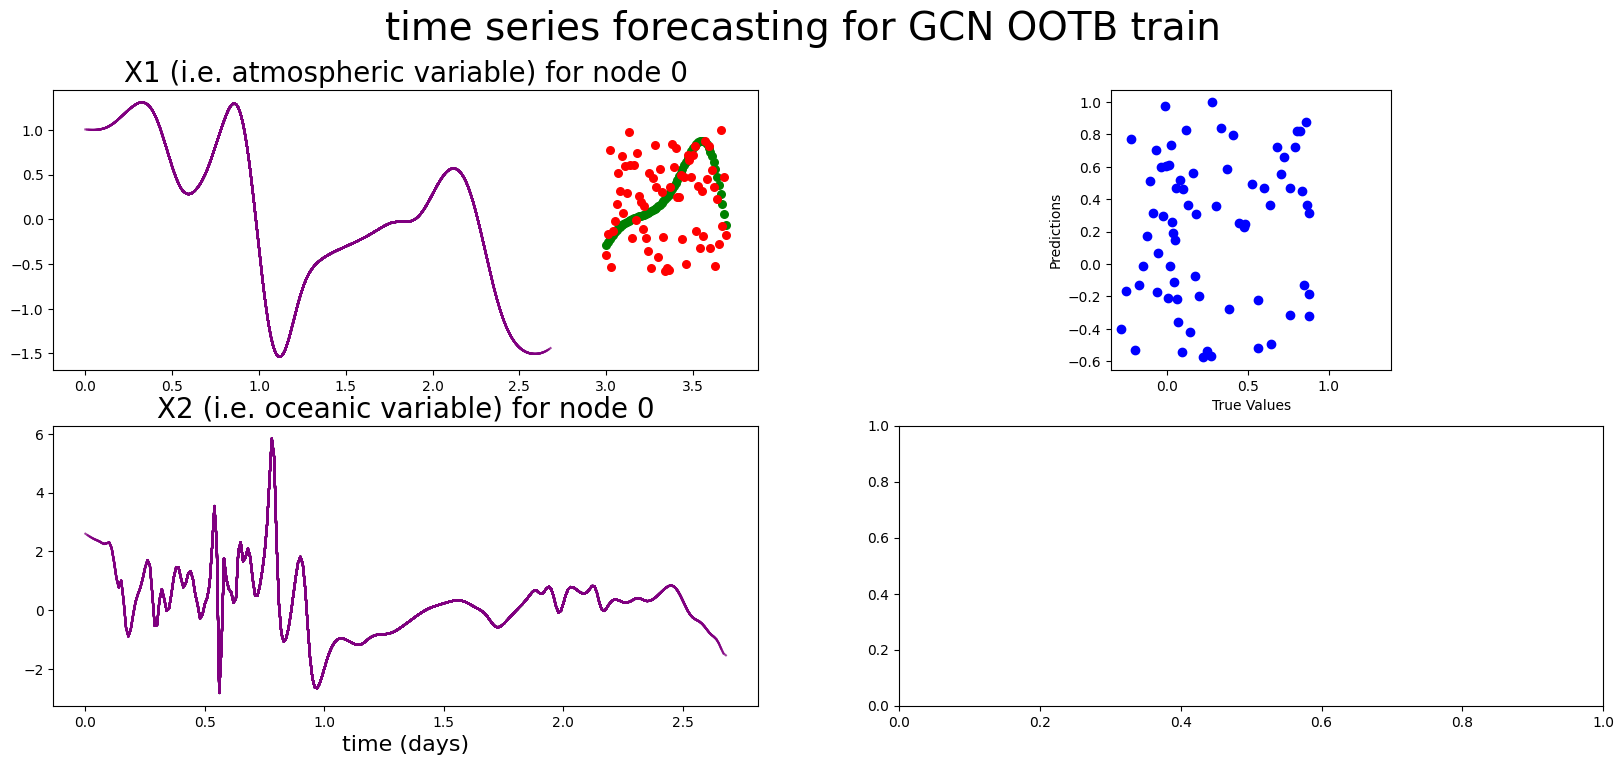

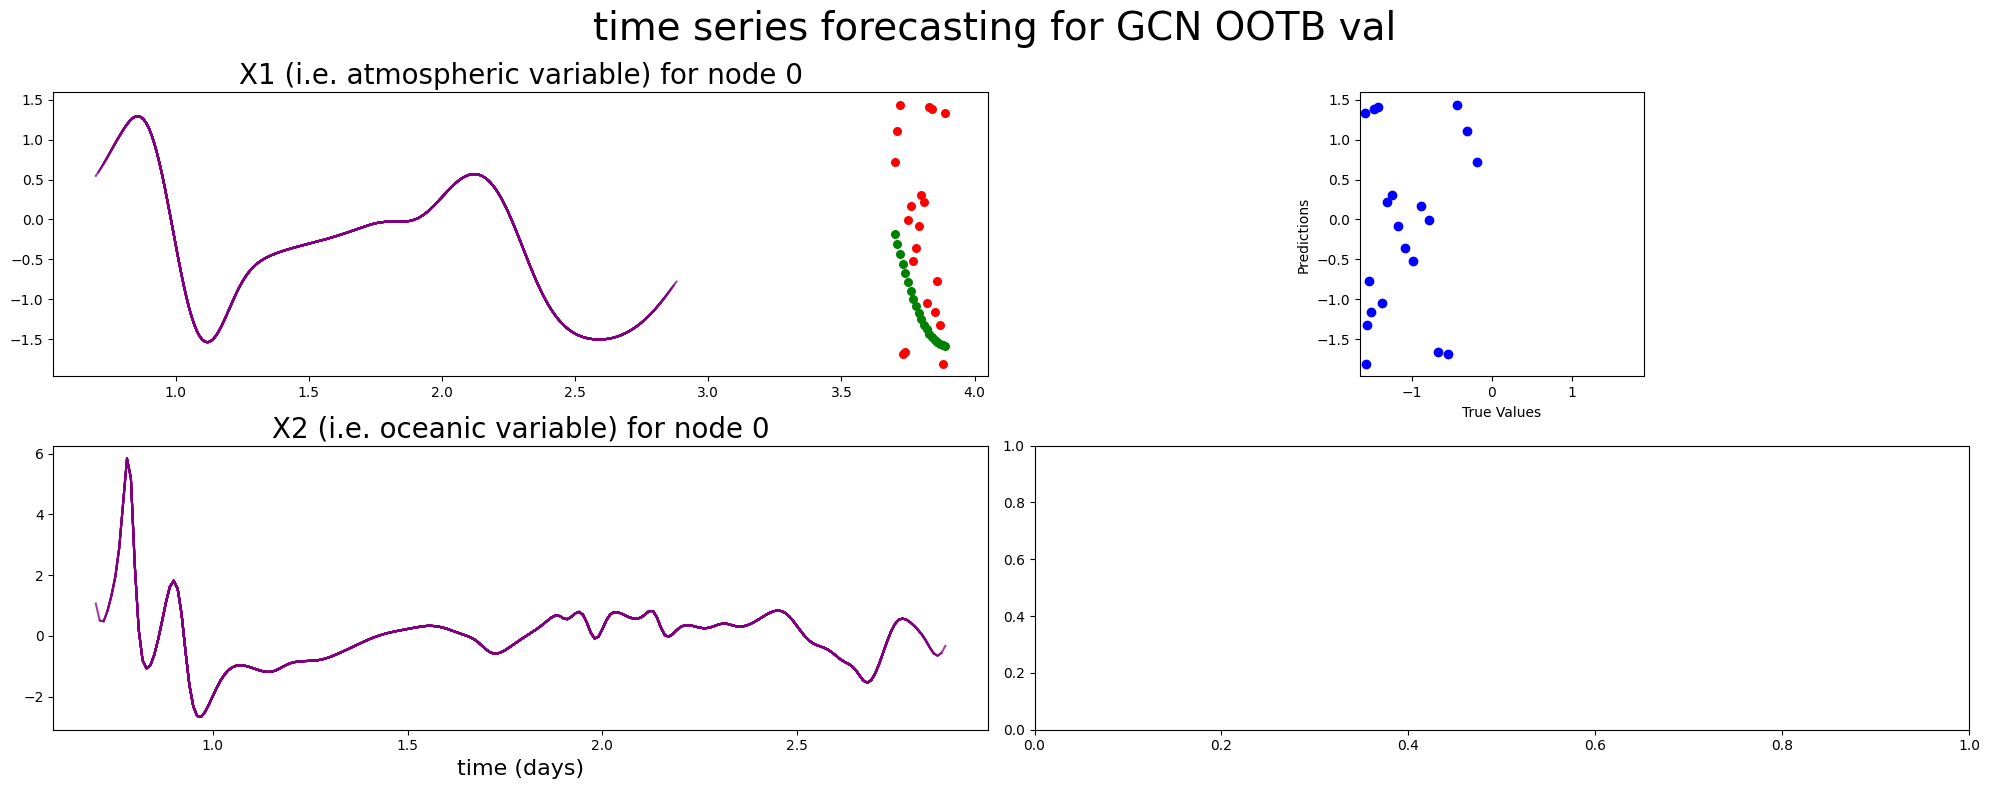

In [87]:
fig_train_loss, fig_train_pred, fig_val_pred = plot_model_results(
    train, val, model, history)


side note: why are the outputs different every time? is there another seed we need to set? 